# Plot point data in grid

Followed these guides.
- [Create fishnet](https://spatial-dev.guru/2022/05/22/create-fishnet-grid-using-geopandas-and-shapely/)
- [Gridding point data in python](https://james-brennan.github.io/posts/fast_gridding_geopandas/)

In [1]:
import os
import configparser

import geopandas as gpd
from shapely.geometry import Point, Polygon

import requests
import json
import pandas as pd

import matplotlib.pyplot as plt

#for colorbar
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib import colors
import numpy as np

from matplotlib import font_manager
#font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

In [2]:
#set filepaths
project_root = os.path.abspath(os.getcwd())
root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
config_file =  os.path.join(root, "config.cfg")

# geodata for shapefiles
config = configparser.ConfigParser()
config.read(config_file)
gdata_root = config["geodata"]["path"]

## Create fishnet grid

Important: You'll need to use an equal-area projection, ie. a projected CRS where each grid cell has the same area. 

For the UK, this is [UTM zone 30N/EPSG:32630](https://epsg.io/32630). You might also be able to use [Lambert Equal Area Europe/EPSG:3035](https://epsg.io/3035).

Some useful tips can be found in [this guide](https://r.geocompx.org/location.html) that uses R to create a fishnet grid map.

In [24]:
# Read shapefile and reproject to coordinate system th
london_all = gpd.GeoDataFrame.from_file(os.path.join(gdata_root, "london-shapefiles\\London_Borough_Excluding_MHW.shp"))
_crs = "EPSG:32630"
london_all = london_all.to_crs(_crs)

#join london boroughs into gdf to work with
london = gpd.GeoDataFrame({'geometry': london_all.unary_union,'index':[0]}, crs=_crs)

# Get the extent of the shapefile
total_bounds = london.total_bounds

# Get minX, minY, maxX, maxY
minX, minY, maxX, maxY = total_bounds

In [4]:
# Create a fishnet
x, y = (minX, minY)
geom_array = []

# Polygon Size (in meters)
square_size = 1000

while y <= maxY:
    while x <= maxX:
        geom = Polygon([(x,y), (x, y+square_size), (x+square_size, y+square_size), (x+square_size, y), (x, y)])
        geom_array.append(geom)
        x += square_size
    x = minX
    y += square_size
fishnet = gpd.GeoDataFrame(geom_array, columns=['geometry']).set_crs(_crs)

#crop fishnet to london shapefile
fishnet = gpd.sjoin(fishnet, london, how='inner').reset_index(drop=True)
fishnet = fishnet.drop(columns=["index", "index_right"])

In [5]:
#save fishnet
fishnet.to_file(os.path.join(gdata_root, "fishnets\\london-1000-1000.geojson"))

(669971.5265748396, 734871.5265748396, 5683342.325711634, 5733942.325711634)

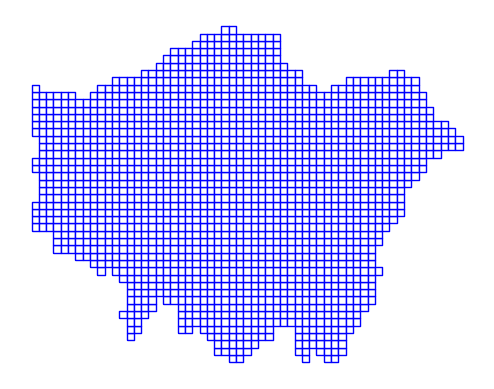

In [6]:
ax = fishnet.plot(color="white", edgecolor="blue")
ax.axis("off")

## Bus stops of London

In [7]:
#get data from OSM using Overpass API
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
area[name="Greater London"][admin_level=5]->.searchArea;

(node["highway"="bus_stop"](area.searchArea); 
);
out center;
"""
response = requests.get(overpass_url, params={'data': overpass_query})
data = response.json()

In [8]:
#convert json into dataframe
df_dict = {"id":[], "type": [], "lat":[], "lon": [],"name":[], "bench":[]}

for element in data['elements']:
    df_dict["id"].append(element["id"])
    df_dict["type"].append(element["type"])
    
    for tag in ["name", "bench"]:
        try:
            df_dict[tag].append(element["tags"][tag])
        except KeyError:
            df_dict[tag].append("") 
    if element["type"]=="node":
        df_dict["lat"].append(element["lat"])
        df_dict["lon"].append(element["lon"])
    else:
        df_dict["lat"].append(element["center"]["lat"])
        df_dict["lon"].append(element["center"]["lon"])
        
df = pd.DataFrame.from_dict(df_dict)

# convert into geodataframe
geometry = [Point(xy) for xy in zip(df['lon'].astype(float), df['lat'].astype(float))]
gdf = gpd.GeoDataFrame(df, crs = 'EPSG:4326', geometry = geometry)

In [9]:
#merge data
gdf = gdf.to_crs(_crs)
merged = gpd.sjoin(gdf, fishnet, how='left')

# make a count variable that we can sum per grid cell
merged['busstops']=1
dissolve = merged.dissolve(by="index_right", aggfunc="count")

# include count in fishnet
fishnet.loc[dissolve.index, 'busstops'] = dissolve["busstops"].values

In [10]:
#dictionary of places to map
places = { "Liverpool St": [51.517633137766545, -0.08060437959423257],
          "Victoria": [51.495589500460675, -0.14321301504775705],
            "Waterloo": [51.50309149257816, -0.1121564478286707]
         }
places = pd.DataFrame.from_dict(places, orient="index", columns=["lat", "lon"])
geometry = [Point(xy) for xy in zip(places['lon'].astype(float), places['lat'].astype(float))]
places = gpd.GeoDataFrame(places, crs = "4326", geometry = geometry)
places = places.to_crs(_crs)
places

,lat,lon,geometry
Liverpool St,51.517633,-0.080604,POINT (702545.325 5711431.133)
Victoria,51.495590,-0.143213,POINT (698298.132 5708808.759)
Waterloo,51.503091,-0.112156,POINT (700420.525 5709727.469)


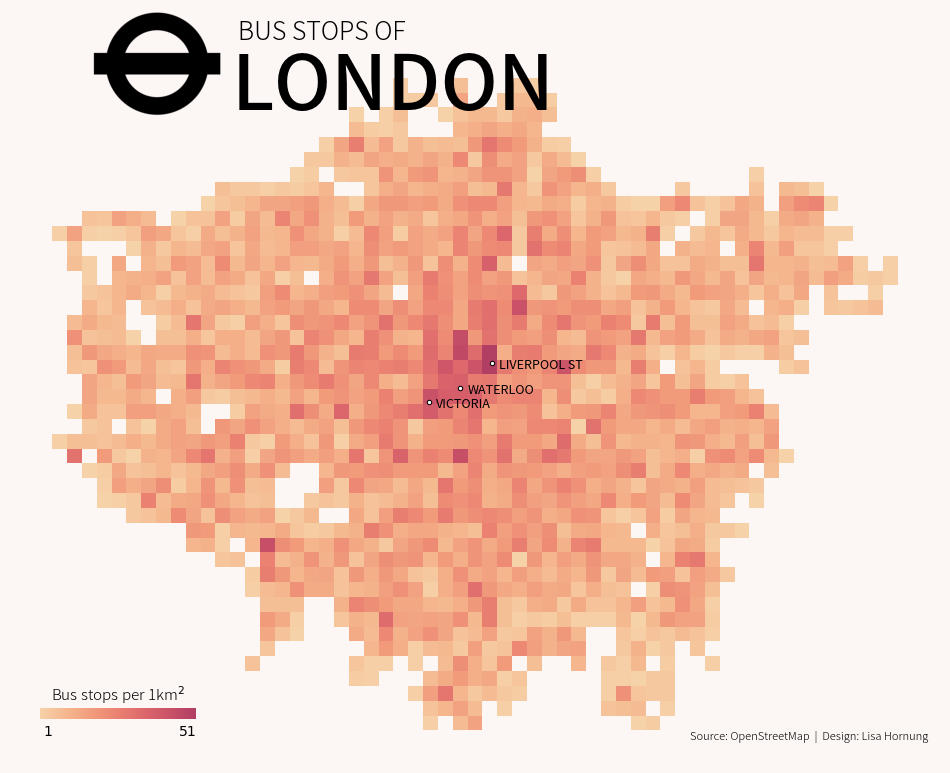

In [13]:
# configuration, colors and fonts
from palettable.cartocolors.sequential import RedOr_7
cmap=RedOr_7.mpl_colormap
bg_color = "#fcf6f5"
title_font = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\NotoSansTC-Medium.otf')
subtitle_font = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\NotoSansTC-Light.otf')
label_font = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\NotoSansTC-Regular.otf')

#plot
fig, ax = plt.subplots(figsize=(12, 10))
fig.set_facecolor(bg_color)

# ===
# Data
values = "busstops"
fishnet.plot(ax=ax, column=values, alpha=1, zorder=1, cmap=cmap)
places.plot(ax=ax, markersize=10, color="white", edgecolor="black", linewidth=0.75)
for i in range(len(places)):
    ax.text(places["geometry"].iloc[i].x+500, places["geometry"].iloc[i].y, places.index[i].upper(),
           fontproperties=label_font, va="center_baseline", ha="left", fontsize=9)
ax.axis("off")

#====
#colorbar
cbaxes = fig.add_axes([0.15, 0.18, 0.13, 0.011]) #axes to hold colorbar
cmappable = ScalarMappable(norm=Normalize(0,1), cmap=cmap)              
cb = plt.colorbar(cmappable, cax=cbaxes, anchor=(1,1.2), orientation='horizontal', drawedges=False,ticks=[0.05,0.95])
cb.set_ticklabels(["1", int(fishnet[values].max())])
cb.outline.set_visible(False)
cbaxes.tick_params(size=0)
cbaxes.text(0.5, 1.7, r"Bus stops per 1km$^2$", ha="center", fontproperties=subtitle_font, size=11, )


# add logo
im = plt.imread('busstops-sign-transparent-v3.png')
newax = fig.add_axes([0.19,0.78,0.11,0.11], anchor='NE', zorder=1)
newax.imshow(im)
newax.axis('off')

#====
# Text
plt.figtext(0.315, 0.88-0.02 , "Bus stops of".upper(), fontproperties=subtitle_font, fontsize=18,  ha="left")
plt.figtext(0.31, 0.81-0.02, "London".upper(), fontproperties=title_font, fontsize=55,  ha="left")
plt.figtext(0.89, 0.16, "Source: OpenStreetMap  |  Design: Lisa Hornung", fontproperties=subtitle_font, fontsize=8, ha="right")

#export
plt.savefig("london-busstops-1skm.png", bbox_inches='tight', pad_inches=0.45, facecolor=bg_color, dpi=300)

plt.show()

## Places of culture in London

In [14]:
#get data from OSM using Overpass API
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
area[name="Greater London"][admin_level=5]->.searchArea;

(node["amenity"~"arts_centre|theatre"](area.searchArea); 
way["amenity"~"arts_centre|theatre"](area.searchArea);
rel["amenity"~"arts_centre|theatre"](area.searchArea);
node["tourism"~"museum|gallery"](area.searchArea); 
way["tourism"~"museum|gallery"](area.searchArea);
rel["tourism"~"museum|gallery"](area.searchArea);
);
out center;
"""
response = requests.get(overpass_url, params={'data': overpass_query})
data = response.json()

In [15]:
#convert json into dataframe
df_dict = {"id":[], "type": [], "lat":[], "lon": [],"name":[], "tourism":[], "amenity":[]}

for element in data['elements']:
    df_dict["id"].append(element["id"])
    df_dict["type"].append(element["type"])
    
    for tag in ["name", "tourism", "amenity"]:
        try:
            df_dict[tag].append(element["tags"][tag])
        except KeyError:
            df_dict[tag].append("") 
    if element["type"]=="node":
        df_dict["lat"].append(element["lat"])
        df_dict["lon"].append(element["lon"])
    else:
        df_dict["lat"].append(element["center"]["lat"])
        df_dict["lon"].append(element["center"]["lon"])
        
df = pd.DataFrame.from_dict(df_dict)

# convert into geodataframe
geometry = [Point(xy) for xy in zip(df['lon'].astype(float), df['lat'].astype(float))]
gdf = gpd.GeoDataFrame(df, crs = 'EPSG:4326', geometry = geometry)
gdf["art_type"] = gdf["tourism"] + gdf["amenity"]

In [16]:
#merge data
gdf = gdf.to_crs(_crs)
merged = gpd.sjoin(gdf, fishnet, how='left')

# make a count variable that we can sum per grid cell
merged['arts']=1
dissolve = merged.dissolve(by="index_right", aggfunc="count")

# include count in fishnet
fishnet.loc[dissolve.index, 'arts'] = dissolve["arts"].values

In [17]:
#dictionary of places to map
places = {  "Covent Garden": [51.512928548426736, -0.12422115775554463]
         }
places = pd.DataFrame.from_dict(places, orient="index", columns=["lat", "lon"])
geometry = [Point(xy) for xy in zip(places['lon'].astype(float), places['lat'].astype(float))]
places = gpd.GeoDataFrame(places, crs = "4326", geometry = geometry)
places = places.to_crs(_crs)

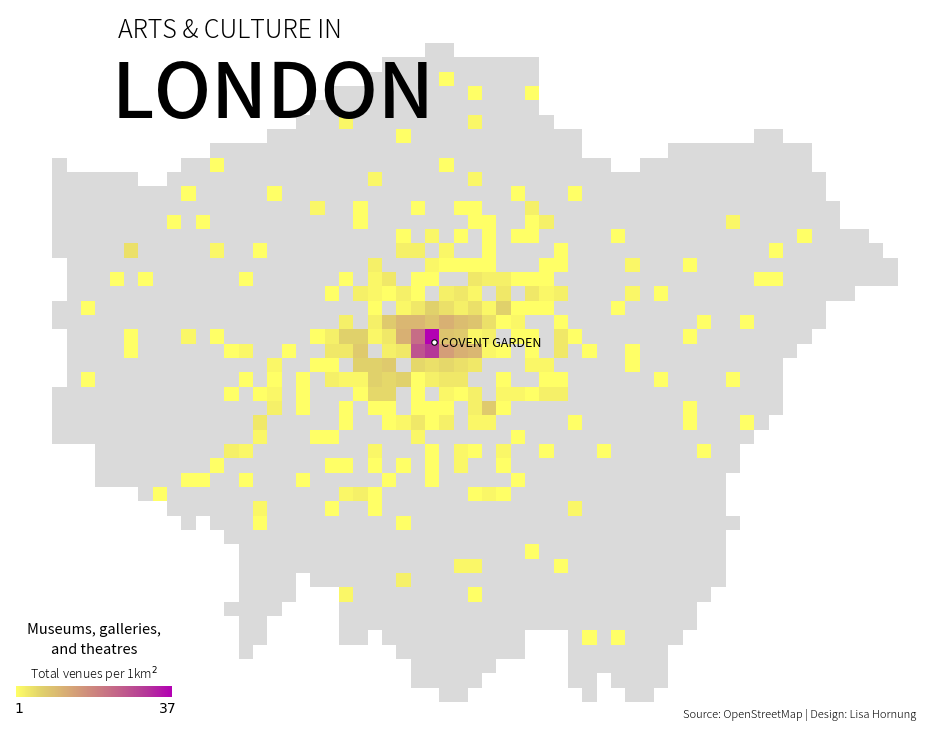

In [23]:
#configuration, colors and fonts
from palettable.scientific.sequential import Buda_7_r
cmap = Buda_7_r.mpl_colormap
bg_color = "white"

title_font = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\NotoSansTC-Medium.otf')
subtitle_font = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\NotoSansTC-Light.otf')
label_font = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\NotoSansTC-Regular.otf')

#plot
fig, ax = plt.subplots(figsize=(12, 10))
fig.set_facecolor(bg_color)

# ===
# Data
fishnet["arts_n"] = fishnet["arts"].fillna(0)
values = "arts"
fishnet.plot(ax=ax, column=values, alpha=1, zorder=3, cmap=cmap)
fishnet.plot(ax=ax, color="#DADADA",zorder=2)
places.plot(ax=ax, markersize=15, color="white", edgecolor="black", linewidth=0.75, zorder=3,)
for i in range(len(places)):
    ax.text(places["geometry"].iloc[i].x+500, places["geometry"].iloc[i].y, places.index[i].upper(),
           fontproperties=label_font, va="center_baseline", ha="left", fontsize=9)
ax.axis("off")

#====
#colorbar
cbaxes = fig.add_axes([0.13, 0.17, 0.13, 0.011]) #axes to hold colorbar
cmappable = ScalarMappable(norm=Normalize(0,1), cmap=cmap)              
cb = plt.colorbar(cmappable, cax=cbaxes, anchor=(1,1.2), orientation='horizontal', drawedges=False,ticks=[0.02,0.97])
cb.set_ticklabels(["1", int(fishnet[values].max())])
cb.outline.set_visible(False)
cbaxes.tick_params(size=0)
cbaxes.text(0.5, 4, "Museums, galleries,\nand theatres", ha="center", fontproperties=label_font,size=10.5,
           linespacing=1.5)
cbaxes.text(0.5, 1.7, r"Total venues per 1km$^2$", ha="center", fontproperties=subtitle_font,size=9, )

#====
# Text
plt.figtext(0.215, 0.88-0.05 , "Arts & culture in".upper(), fontproperties=subtitle_font, fontsize=18,  ha="left")
plt.figtext(0.21, 0.8-0.05, "London".upper(), fontproperties=title_font, fontsize=55,  ha="left")
plt.figtext(0.88, 0.15, "Source: OpenStreetMap | Design: Lisa Hornung", fontproperties=subtitle_font, fontsize=8, ha="right")

#export
plt.savefig("london-arts-culture-1skm.png", bbox_inches='tight', dpi=300, pad_inches=0.45, facecolor=bg_color)

plt.show()